Time series forecasting. Starting from stocks returns we want to forecast the return using arma model. The returns used are daily. 


In [1]:
import sys
!{sys.executable} -m pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas import DataFrame
import scipy.stats as sst
from pandas_datareader import data as pdr
from scipy.stats import norm
from datetime import date
import math
import statsmodels as ss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA



You should consider upgrading via the 'C:\Users\marti\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
#asking the user which stock to take
stock = input('What stock should the model be performed on?: ')

What stock should the model be performed on?: MSFT


Here we define the date for the training sample and then for the forecast (in sample training and in sample forecast)

In [3]:
#deciding how big the training sample should be

length_training_sample = int(input('How many days should the training sample be:?'))


end_training = dt.date(2018,1,1)
start_training = end_training - dt.timedelta(days = length_training_sample)

#out of sample forecast dates
start_forecast = end_training + dt.timedelta(days = 1)
end_forecast = date.today()

print('The start of the training is ' + str(start_training) +', the end of the training is ' + str(end_training) +
      ', the start of forecast is ' + str(start_forecast) + ', the end of the forecast is ' + str(end_forecast))

How many days should the training sample be:?15000
The start of the training is 1976-12-07, the end of the training is 2018-01-01, the start of forecast is 2018-01-02, the end of the forecast is 2021-11-28


In [4]:
#downloading the returns for the stock
stock_data = pdr.get_data_yahoo(stock,start_training,end_training)
stock_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1986-03-13,0.101563,0.088542,0.088542,0.097222,1.031789e+09,0.061378
1986-03-14,0.102431,0.097222,0.097222,0.100694,3.081600e+08,0.063570
1986-03-17,0.103299,0.100694,0.100694,0.102431,1.331712e+08,0.064667
1986-03-18,0.103299,0.098958,0.102431,0.099826,6.776640e+07,0.063022
1986-03-19,0.100694,0.097222,0.099826,0.098090,4.789440e+07,0.061926
...,...,...,...,...,...,...
2017-12-22,85.629997,84.919998,85.400002,85.510002,1.414580e+07,81.280579
2017-12-26,85.529999,85.029999,85.309998,85.400002,9.891200e+06,81.176041
2017-12-27,85.980003,85.220001,85.650002,85.709999,1.467800e+07,81.470695


In [5]:
#keeping only the Close column
stock_data_close = stock_data.Close
stock_data_close


Date
1986-03-13     0.097222
1986-03-14     0.100694
1986-03-17     0.102431
1986-03-18     0.099826
1986-03-19     0.098090
                ...    
2017-12-22    85.510002
2017-12-26    85.400002
2017-12-27    85.709999
2017-12-28    85.720001
2017-12-29    85.540001
Name: Close, Length: 8018, dtype: float64

In [6]:
#features of the returns
stock_data_close.describe()

count    8018.000000
mean       22.669250
std        18.138093
min         0.090278
25%         2.840820
50%        25.680000
75%        30.927500
max        86.849998
Name: Close, dtype: float64

Here we perform graphical analysis on the stock prices (time series, graph for rolling mean and standard deviation and histogram). The rolling mean and standard deviation can also be used to inspect graphically the stationarity of a process.

How many days for the rolling?40


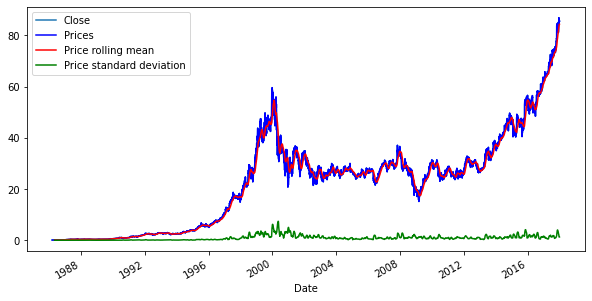

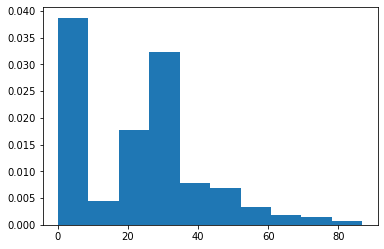

C:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

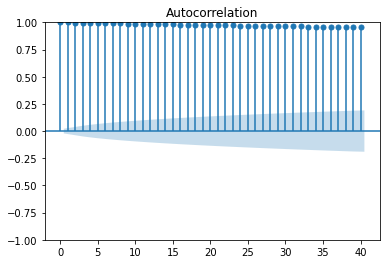

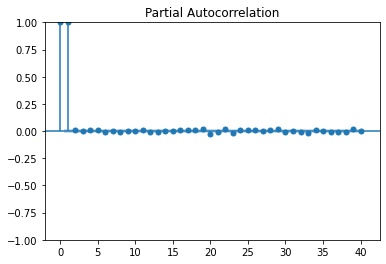

In [7]:
#graph of the prices, with rolling mean and standard deviation and histogram of the prices
window_rolling = int(input('How many days for the rolling?'))
stock_data_close.plot(figsize=(10,5))
rolling_mean_prices = stock_data_close.rolling(window = window_rolling).mean()
rolling_std_prices = stock_data_close.rolling(window = window_rolling).std()
plt.plot(stock_data_close,color ='blue',label ='Prices')
plt.plot(rolling_mean_prices, color = 'red',label='Price rolling mean')
plt.plot(rolling_std_prices,color = 'green',label='Price standard deviation')
plt.legend(loc ='best')
plt.show()
stock_price_hist = plt.hist(stock_data_close,density = True)
plt.show()

#acf and pacf of the prices
plot_acf(stock_data_close)
plot_pacf(stock_data_close)
plt.show

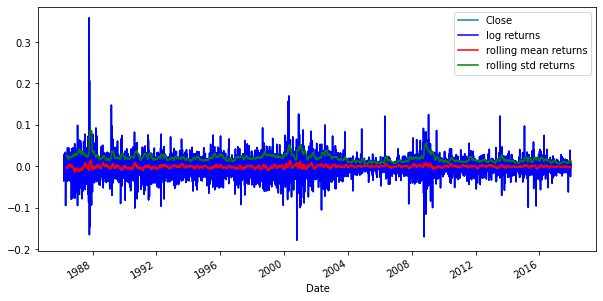

C:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


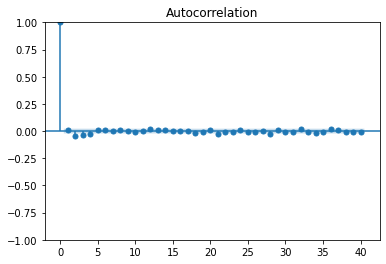

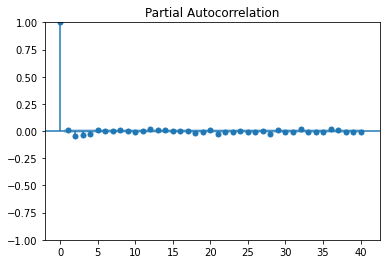

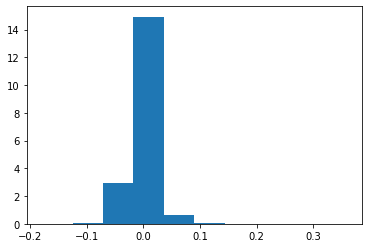

In [8]:
#getting the returns and plotting the returns + acf and pacf
returns = np.log(stock_data_close/stock_data_close.shift(-1))
returns = returns.dropna()
returns 

returns.plot(figsize=(10,5))
rolling_mean_returns = returns.rolling(window = window_rolling).mean()
rolling_std_returns = returns.rolling(window = window_rolling).std()
plt.plot(returns,color = 'blue', label = 'log returns')
plt.plot(rolling_mean_returns, color ='red', label ='rolling mean returns')
plt.plot(rolling_std_returns, color = 'green', label ='rolling std returns')
plt.legend(loc = 'best')
plt.show()

plot_acf(returns)
plot_pacf(returns)
plt.show()
returns_hist = plt.hist(returns,density = True)


In [9]:

#calculating skewness
skewness_returns = sst.skew(returns)

#calculating kurtosis
kurtosis_returns = sst.kurtosis(returns)

print('The skewness of the returns is '+str(skewness_returns) + ' and the kurtosis is '+ str(kurtosis_returns))

The skewness of the returns is 0.6099024268034369 and the kurtosis is 15.433675781379208


In [10]:
#stationarity tests. We perform the following analysis: dickey fuller (null hypothesis is ar 1 with phi = 1 ==> random walk)
# adf with default number of lags ==> non stationary process as H0 but we cannot say random walk for sure
# kpss, H0 is trend stationary or has no unit root

#adf test
adf_test = ss.tsa.stattools.adfuller(returns,None,'c',None,False,False)

print(' the p value for adf is ' + str(adf_test[1]))


 the p value for adf is 5.610607680706843e-28


In [11]:
#fitting arima model
returns = returns.asfreq('d')
model_arima = ARIMA(returns,order=(2,0,2))
model_fit = model_arima.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                11614
Model:                 ARIMA(2, 0, 2)   Log Likelihood               19348.461
Date:                Sun, 28 Nov 2021   AIC                         -38684.921
Time:                        20:17:22   BIC                         -38640.762
Sample:                    03-13-1986   HQIC                        -38670.084
                         - 12-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.000     -3.426      0.001      -0.001      -0.000
ar.L1          0.7111      0.094      7.538      0.000       0.526       0.896
ar.L2         -0.2658      0.091     -2.907      0.0

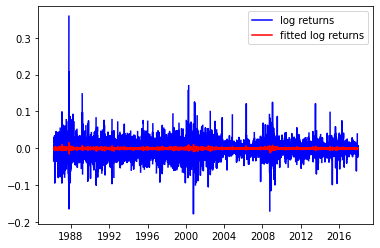

In [14]:
plt.plot(returns,color='blue',label ='log returns')
plt.plot(model_fit.fittedvalues, color = 'red', label = 'fitted log returns')
plt.legend(loc ='best')
plt.show()


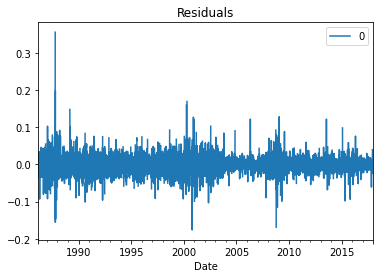

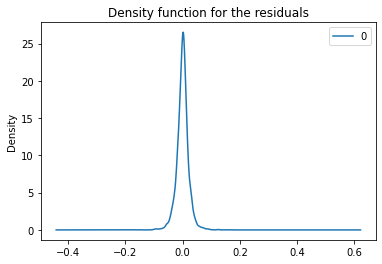

In [13]:
#residuals from the model
residuals_arima = DataFrame(model_fit.resid)

residuals_arima.plot()
plt.title('Residuals')
plt.show()

residuals_arima.plot(kind ='kde')
plt.title('Density function for the residuals')
plt.show()

